# Business Understanding

## Project Domain

In [43]:
# Clustering malaria di kabupan/kota Jawa Barat.

In [44]:
# Proyek ini berfokus pada pemetaan karakteristik wilayah di Jawa Barat berdasarkan indikator kesehatan (Malaria), fasilitas kesehatan (Puskesmas), sanitasi lingkungan, dan kepadatan penduduk.
# Fokus utamanya adalah menganalisis persebaran penyakit Malaria di Provinsi Jawa Barat dengan mempertimbangkan faktor pendukung seperti ketersediaan fasilitas kesehatan (Puskesmas) dan kondisi sanitasi lingkungan.

## Problem Statements

In [45]:
# Distribusi Kasus Tidak Merata: Sulitnya mengidentifikasi pola penyebaran malaria hanya dengan melihat tabel data mentah.
# Keterbatasan Sumber Daya: Pemerintah perlu mengetahui daerah mana yang harus diprioritaskan untuk penyuluhan sanitasi atau penambahan fasilitas kesehatan.
# Belum Ada Pengelompokan Jelas: Belum adanya klasterisasi wilayah (Zona Aman, Waspada, Bahaya) berdasarkan gabungan indikator kesehatan dan lingkungan.

## Goals

In [46]:
# Mengelompokkan Kabupaten/Kota di Jawa Barat menjadi beberapa klaster (cluster) berdasarkan kemiripan karakteristik jumlah kasus malaria, ketersediaan puskesmas, persentase sanitasi layak, dan kepadatan penduduk.
# Menemukan pola hubungan antara kualitas sanitasi, kepadatan penduduk, dan ketersedian fasilitas kesehatan dengan tingkat kasus malaria.
# Mengidentifikasi daerah yang memerlukan penanganan prioritas (misal: sanitasi buruk atau kasus tinggi).

## Solution Statements

In [47]:
# Menggunakan algoritma K-Means Clustering untuk mengelompokkan wilayah.
# Menggunakan metode Elbow untuk menentukan jumlah klaster optimal.
# Mengevaluasi hasil klaster menggunakan Silhouette Score.

# Data Understanding

## Dataset Description

In [48]:
# Dataset yang digunakan berasal dari Open Data Jawa Barat yang mencakup data tahun 2018-2024.
# Sumber: Open Data Jabar.
# Jumlah Data: 189 baris (Kabupaten/Kota per tahun).
# Fitur Utama: Jumlah Kasus Malaria, Jumlah Puskesmas, Persentase Sanitasi Layak, dan Kepadatan Penduduk.

In [49]:
# Link dataset:
# https://opendata.jabarprov.go.id/id/dataset/jumlah-kasus-penyakit-malaria-berdasarkan-kabupatenkota-di-jawa-barat
# https://opendata.jabarprov.go.id/id/dataset/jumlah-puskesmas-berdasarkan-kabupatenkota-di-jawa-barat
# https://opendata.jabarprov.go.id/id/dataset/persentase-keluarga-dengan-akses-sanitasi-layak-jamban-sehat-berdasarkan-kabupatenkota-di-jawa-barat
# https://opendata.jabarprov.go.id/id/dataset/kepadatan-penduduk-berdasarkan-kabupatenkota-di-jawa-barat

In [50]:
# jelaskan cara membuat datasetnya
# Dataset final yang digunakan dalam proyek ini merupakan hasil penggabungan dari tiga dataset terpisah yang bersumber dari Open Data Jawa Barat. Proses pembentukan dataset melibatkan langkah-langkah berikut:
# 1. Pengumpulan Data Mentah:
#    * Data Jumlah Kasus Malaria (Target/Variabel Utama).
#    * Data Jumlah Puskesmas (Faktor Fasilitas Kesehatan).
#    * Data Persentase Sanitasi Layak (Faktor Lingkungan).
#    * Data Kepadatan Penduduk (Faktor Demografi).
# 2. Pembersihan Awal (Cleaning):
#    * Menyamakan format penulisan angka desimal (mengubah koma ',' menjadi titik '.').
#    * Memastikan keseragaman nama Kabupaten/Kota sebagai kunci penggabungan.
# 3. Penggabungan (Merging):
#    * Ketiga dataset digabungkan menggunakan metode **Inner Join** berdasarkan kunci 'nama_kabupaten_kota' dan 'tahun'.
#    * Hanya data yang memiliki irisan tahun dan lokasi yang sama yang dipertahankan untuk menjaga konsistensi.
# Hasil akhirnya adalah dataset 'MALARIA_cleaned.csv' yang berisi kolom gabungan: 'nama_kabupaten_kota', 'tahun', 'jumlah_kasus', 'jumlah_puskesmas', 'persentase_sanitasi_layak', dan 'kepadatan_penduduk'.

# Load langsung tanpa pengecekan error
df_malaria = pd.read_csv('Dataset Kasus Malaria.csv')
df_sanitasi = pd.read_csv('Dataset Kelayakan Sanitasi.csv')
df_puskesmas = pd.read_csv('Dataset Faskes.csv')
df_kepadatan = pd.read_csv('Dataset Kepadatan Penduduk.csv')

# Cleaning Sanitasi: pastikan decimal separator '.' (gunakan regex=False untuk pandas >=1.4)
df_sanitasi['persentase_sanitasi_layak'] = df_sanitasi['persentase_sanitasi_layak'].astype(str).str.replace(',', '.', regex=False).astype(float)

# Standarisasi Kolom Kunci
for _df in [df_malaria, df_sanitasi, df_puskesmas, df_kepadatan]:
    _df['nama_kabupaten_kota'] = _df['nama_kabupaten_kota'].str.upper().str.strip()
    _df['tahun'] = _df['tahun'].astype(int)

# Pilih hanya kolom yang diperlukan dari masing-masing dataset untuk menghindari duplikasi nama kolom saat merge
df_malaria_sel = df_malaria[['nama_kabupaten_kota', 'tahun', 'jumlah_kasus']].copy()
df_sanitasi_sel = df_sanitasi[['nama_kabupaten_kota', 'tahun', 'persentase_sanitasi_layak']].copy()
df_puskesmas_sel = df_puskesmas[['nama_kabupaten_kota', 'tahun', 'jumlah_puskesmas']].copy()
df_kepadatan_sel = df_kepadatan[['nama_kabupaten_kota', 'tahun', 'kepadatan_penduduk']].copy()

# Lakukan merge bertahap pada kolom yang sudah unik sehingga tidak akan ada duplikasi nama kolom
df_merge = df_malaria_sel.merge(df_sanitasi_sel, on=['nama_kabupaten_kota', 'tahun'], how='inner')
df_merge = df_merge.merge(df_puskesmas_sel, on=['nama_kabupaten_kota', 'tahun'], how='inner')
df_merge = df_merge.merge(df_kepadatan_sel, on=['nama_kabupaten_kota', 'tahun'], how='inner')

# Jika Anda ingin memastikan tidak ada duplikat baris:
df_merge = df_merge.drop_duplicates(subset=['nama_kabupaten_kota', 'tahun'])

print(f"Hasil merge shape: {df_merge.shape}")

# Seleksi kolom final (sudah sesuai)
kolom_final = ['nama_kabupaten_kota', 'tahun', 'jumlah_kasus', 'persentase_sanitasi_layak', 'jumlah_puskesmas', 'kepadatan_penduduk']
dataset_final = df_merge[kolom_final]

# Simpan ke CSV
dataset_final.to_csv('MALARIA_gabungan.csv', index=False)

print("Selesai! Preview data:")
print(dataset_final.head())
print("\nInfo:")
print(dataset_final.info())

Hasil merge shape: (189, 6)
Selesai! Preview data:
  nama_kabupaten_kota  tahun  jumlah_kasus  persentase_sanitasi_layak  \
0     KABUPATEN BOGOR   2018             7                      73.96   
1  KABUPATEN SUKABUMI   2018            36                      56.36   
2   KABUPATEN CIANJUR   2018             0                      75.03   
3   KABUPATEN BANDUNG   2018             9                      75.10   
4     KABUPATEN GARUT   2018             0                      76.09   

   jumlah_puskesmas  kepadatan_penduduk  
0               101                2155  
1                58                 594  
2                45                 589  
3                62                2103  
4                67                 848  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   nama_kabupaten_kota        189

## Libary Requirements

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score)

## Exploratory Data Analysis

In [52]:
# Buatkan EDA dan berikan deskripsinya :
df = pd.read_csv("MALARIA_cleaned.csv")

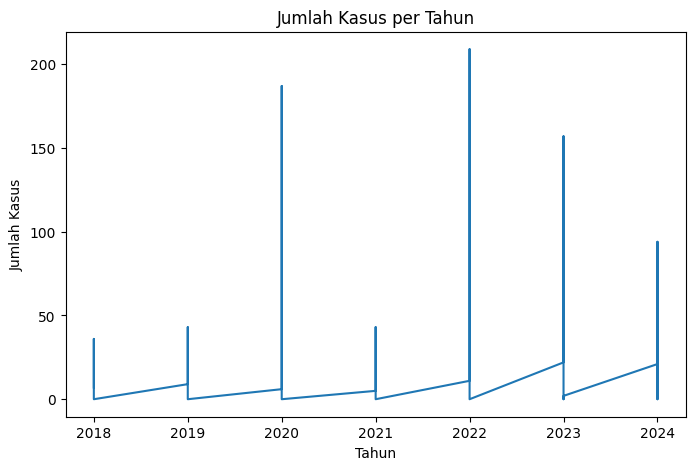

In [53]:
# Line Plot 1: Jumlah kasus per tahun
plt.figure(figsize=(8,5))
plt.plot(df["tahun"], df["jumlah_kasus"])
plt.xlabel("Tahun")
plt.ylabel("Jumlah Kasus")
plt.title("Jumlah Kasus per Tahun")
plt.show()

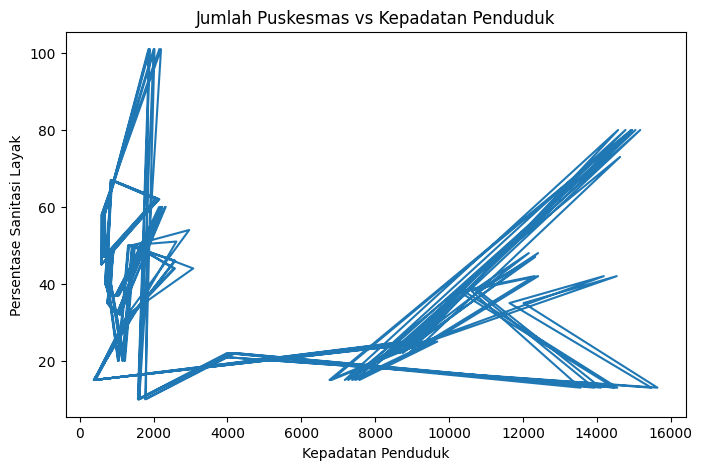

In [54]:
#  Line Plot 2: Jumlah Puskesmas vs Kepadatan Penduduk
plt.figure(figsize=(8,5))
plt.plot(df["kepadatan_penduduk"], df["jumlah_puskesmas"])
plt.xlabel("Kepadatan Penduduk")
plt.ylabel("Persentase Sanitasi Layak")
plt.title("Jumlah Puskesmas vs Kepadatan Penduduk")
plt.show()

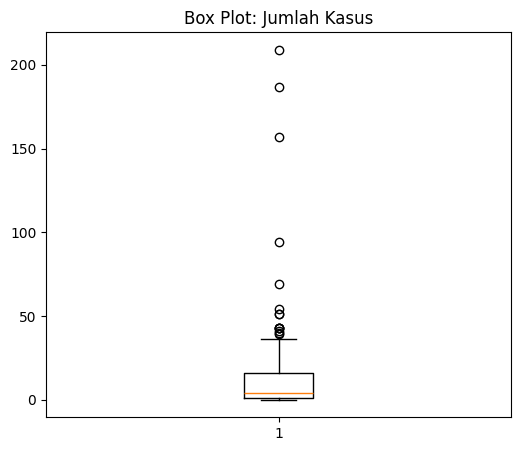

In [55]:
# Boxplot 1: jumlah kasus
plt.figure(figsize=(6,5))
plt.boxplot(df["jumlah_kasus"])
plt.title("Box Plot: Jumlah Kasus")
plt.show()

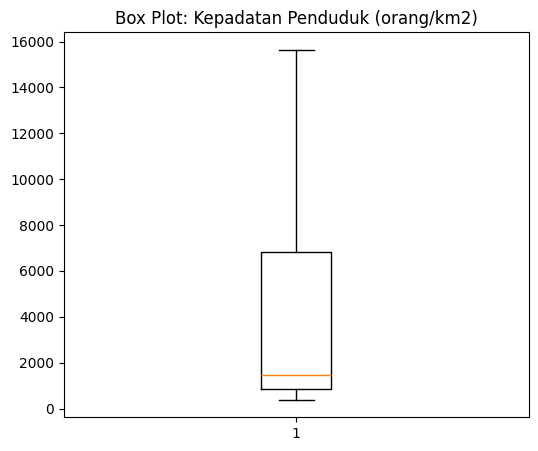

In [56]:
#  Boxplot 2: kepadatan penduduk
plt.figure(figsize=(6,5))
plt.boxplot(df["kepadatan_penduduk"])
plt.title("Box Plot: Kepadatan Penduduk (orang/km2)")
plt.show()

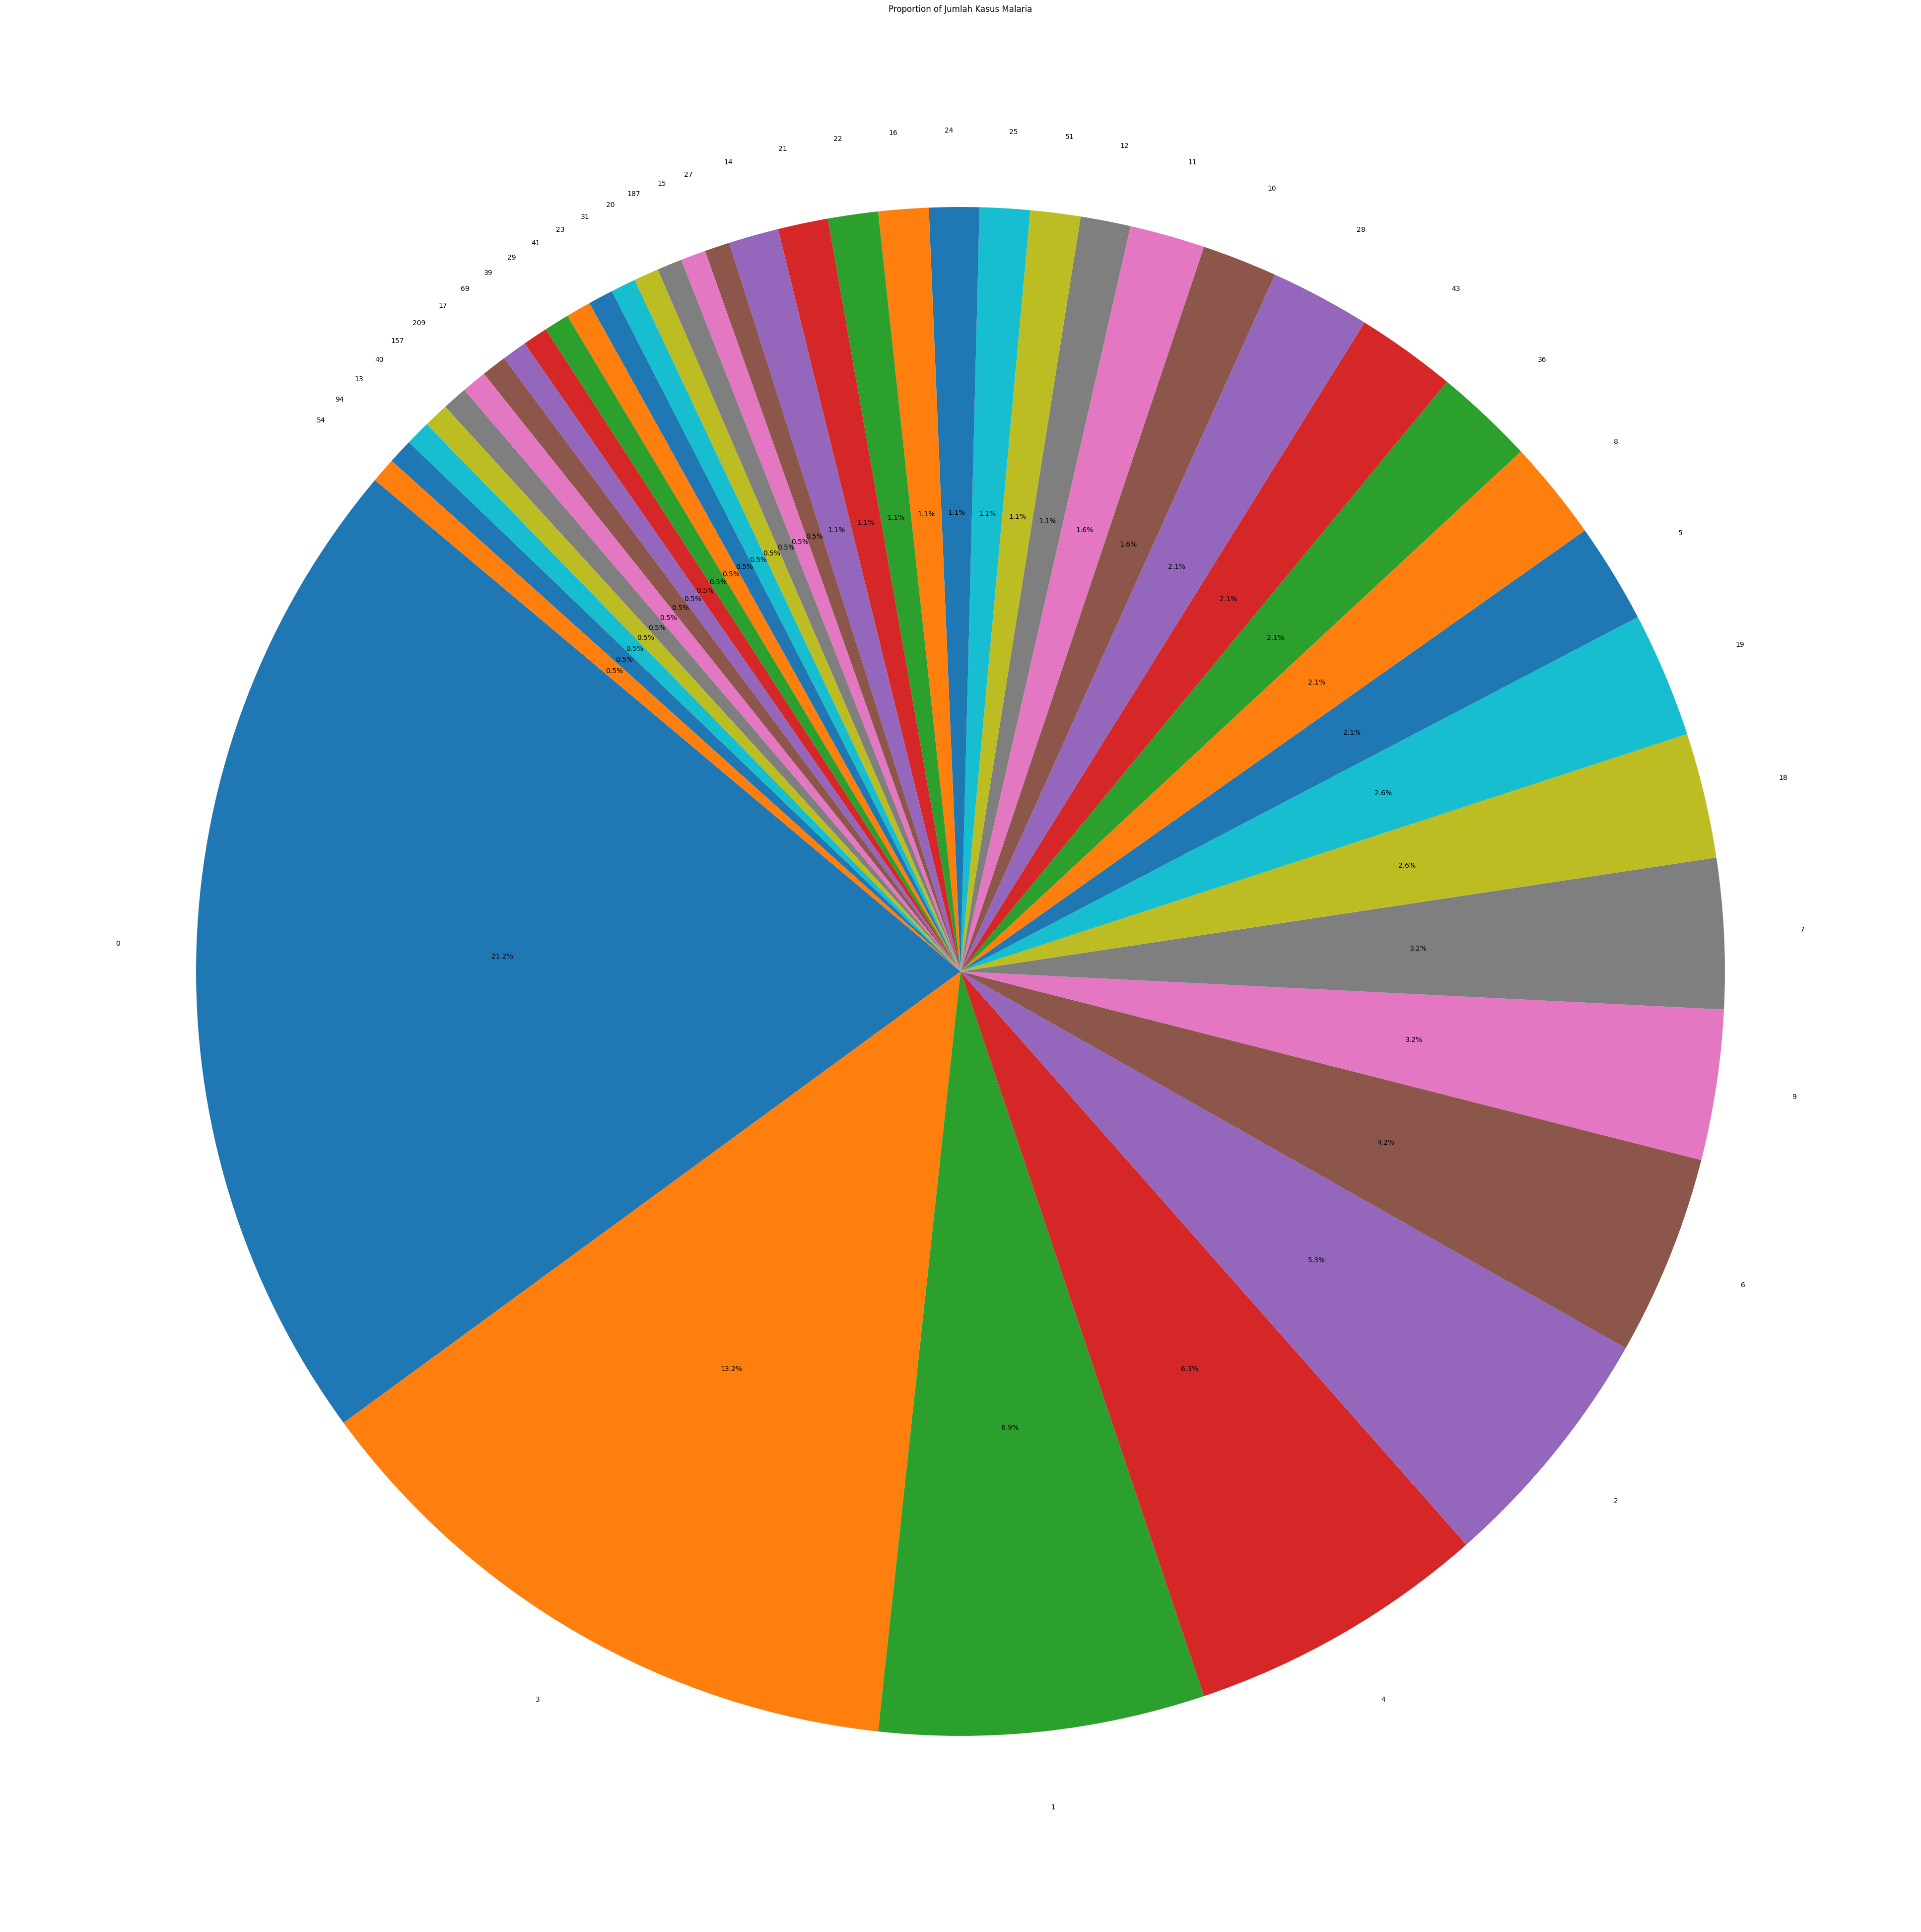

In [57]:
# Pie Chart 1: jumlah kasus
plt.figure(figsize=(50, 50))
df['jumlah_kasus'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Jumlah Kasus Malaria")
plt.ylabel("")
plt.show()

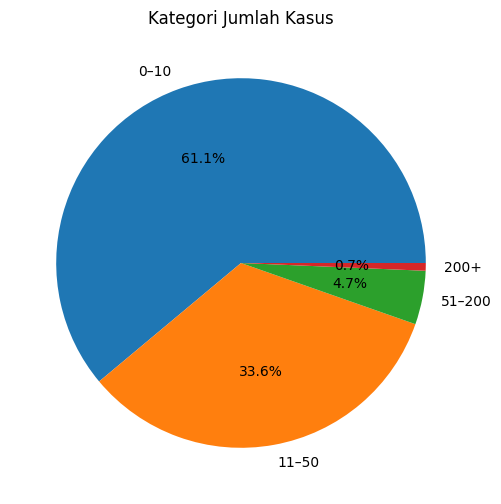

In [58]:
# Pie Chart 2: Kategori jumlah kasus
bins = [0, 10, 50, 200, 10000]
labels = ["0–10", "11–50", "51–200", "200+"]
df["kategori_kasus"] = pd.cut(df["jumlah_kasus"], bins=bins, labels=labels)

pie = df["kategori_kasus"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(pie, labels=pie.index, autopct="%1.1f%%")
plt.title("Kategori Jumlah Kasus")
plt.show()

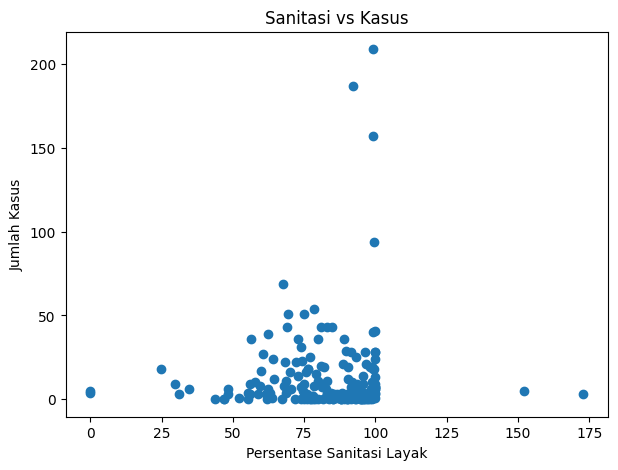

In [59]:
# Scatter Plot
plt.figure(figsize=(7,5))
plt.scatter(df["persentase_sanitasi_layak"], df["jumlah_kasus"])
plt.xlabel("Persentase Sanitasi Layak")
plt.ylabel("Jumlah Kasus")
plt.title("Sanitasi vs Kasus")
plt.show()

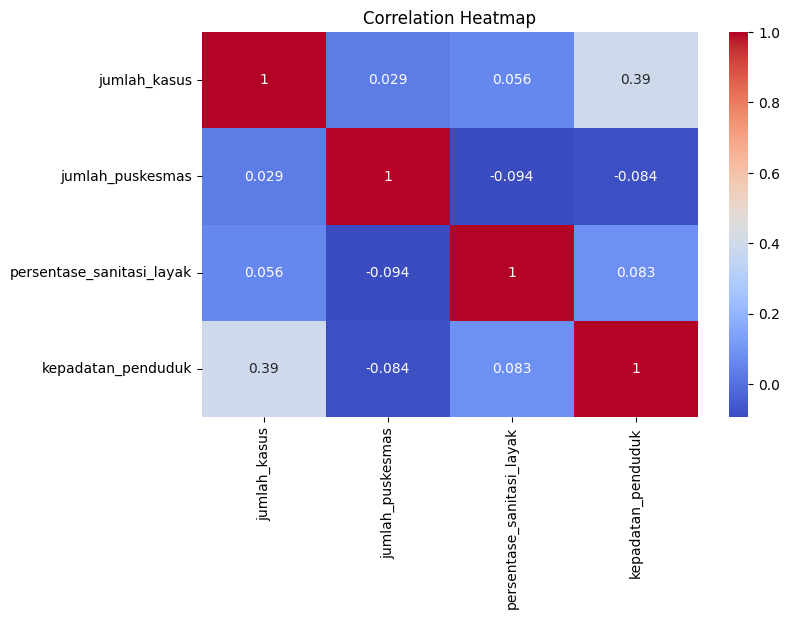

In [60]:
# corelation matrix
plt.figure(figsize=(8, 5))
sns.heatmap(df[["jumlah_kasus","jumlah_puskesmas","persentase_sanitasi_layak","kepadatan_penduduk"]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Data Preparation

## Dataset Information

In [61]:
# berikan informasi dataset seperti jumlah kolom, jumlah baris, tipe data, dll
df = pd.read_csv('MALARIA_cleaned.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   nama_kabupaten_kota        189 non-null    object 
 1   jumlah_kasus               189 non-null    int64  
 2   jumlah_puskesmas           189 non-null    int64  
 3   persentase_sanitasi_layak  189 non-null    float64
 4   kepadatan_penduduk         189 non-null    int64  
 5   tahun                      189 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 9.0+ KB


,nama_kabupaten_kota,jumlah_kasus,jumlah_puskesmas,persentase_sanitasi_layak,kepadatan_penduduk,tahun
0,KABUPATEN BOGOR,7,101,73.96,2155,2018
1,KABUPATEN SUKABUMI,36,58,56.36,594,2018
2,KABUPATEN CIANJUR,0,45,75.03,589,2018
3,KABUPATEN BANDUNG,9,62,75.10,2103,2018
4,KABUPATEN GARUT,0,67,76.09,848,2018


## Dataset Transformation

In [62]:
# jelaskan bagaimana dataset ditransformasikan sebelum diolah menggunakan model ML
# Transformasi Data (Data Transformation)
# Sebelum data dimasukkan ke dalam algoritma K-Means Clustering, dilakukan beberapa tahapan transformasi agar model dapat bekerja secara optimal:
# 1.  **Feature Selection (Seleksi Fitur):**
#    * Hanya memilih kolom numerik yang relevan untuk proses clustering, yaitu: 'jumlah_kasus', 'jumlah_puskesmas', 'persentase_sanitasi_layak', 'kepadatan_penduduk'.
#    * Kolom identitas seperti 'nama_kabupaten_kota' dan 'tahu' dipisahkan sementara karena tidak ikut dihitung dalam kalkulasi jarak matematis.
# 2.  **Standardization (Standarisasi Data):**
#    * Algoritma K-Means menggunakan perhitungan jarak (Euclidean Distance). Jika skala data antar fitur berbeda jauh (contoh: *Jumlah Kasus* berkisar 0-200, sedangkan *Sanitasi* 0-100), maka fitur dengan angka besar akan mendominasi hasil cluster.
#    * Oleh karena itu, digunakan **Standard Scaler** (Z-Score Standardization) untuk mengubah distribusi data sehingga setiap fitur memiliki rata-rata (mean) = 0 dan standar deviasi = 1.

In [63]:
# 1. Seleksi Fitur (Membuang kolom teks/kategorikal)
# Kita hanya mengambil data angka untuk dikalkulasi
X = df[['jumlah_kasus', 'jumlah_puskesmas', 'persentase_sanitasi_layak', 'kepadatan_penduduk']]

# 2. Standarisasi (Standard Scaler)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mengubah kembali ke DataFrame agar mudah dilihat (Opsional)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Statistik Data Setelah Transformasi (Mean mendekati 0, Std mendekati 1):")
print(X_scaled_df.describe().round(2))
print("\nContoh 5 Data Teratas:")
print(X_scaled_df.head())

Statistik Data Setelah Transformasi (Mean mendekati 0, Std mendekati 1):
       jumlah_kasus  jumlah_puskesmas  persentase_sanitasi_layak  \
count        189.00            189.00                     189.00   
mean           0.00             -0.00                      -0.00   
std            1.00              1.00                       1.00   
min           -0.50             -1.46                      -4.17   
25%           -0.46             -0.89                      -0.44   
50%           -0.35             -0.12                       0.22   
75%            0.11              0.45                       0.65   
max            7.50              2.89                       4.56   

       kepadatan_penduduk  
count              189.00  
mean                -0.00  
std                  1.00  
min                 -0.77  
25%                 -0.67  
50%                 -0.54  
75%                  0.63  
max                  2.55  

Contoh 5 Data Teratas:
   jumlah_kasus  jumlah_puskesmas  per

## Determine Variabels

In [64]:
# tentukan variabel apa saja yang digunakan sebagai fitur/label
# 1. Membaca data yang sudah bersih
df = pd.read_csv('MALARIA_cleaned.csv')

# 2. Menentukan fitur yang digunakan
features = [
    'jumlah_kasus', 
    'persentase_sanitasi_layak', 
    'kepadatan_penduduk', 
    'jumlah_puskesmas'
]

X = df[features]

# 3. MENAMPILKAN PERBEDAAN
print("--- Data Asli (Dengan Identitas) ---")
print(df[['nama_kabupaten_kota', 'tahun'] + features].head())

print("\n--- Data Siap Training (Hanya Fitur Numerik) ---")
print(X.head())

# Cek tipe data untuk memastikan semua sudah numerik (float/int)
print("\n--- Tipe Data Fitur ---")
print(X.dtypes)

--- Data Asli (Dengan Identitas) ---
  nama_kabupaten_kota  tahun  jumlah_kasus  persentase_sanitasi_layak  \
0     KABUPATEN BOGOR   2018             7                      73.96   
1  KABUPATEN SUKABUMI   2018            36                      56.36   
2   KABUPATEN CIANJUR   2018             0                      75.03   
3   KABUPATEN BANDUNG   2018             9                      75.10   
4     KABUPATEN GARUT   2018             0                      76.09   

   kepadatan_penduduk  jumlah_puskesmas  
0                2155               101  
1                 594                58  
2                 589                45  
3                2103                62  
4                 848                67  

--- Data Siap Training (Hanya Fitur Numerik) ---
   jumlah_kasus  persentase_sanitasi_layak  kepadatan_penduduk  \
0             7                      73.96                2155   
1            36                      56.36                 594   
2             0         

# Modeling

## Modeling classification / clustering

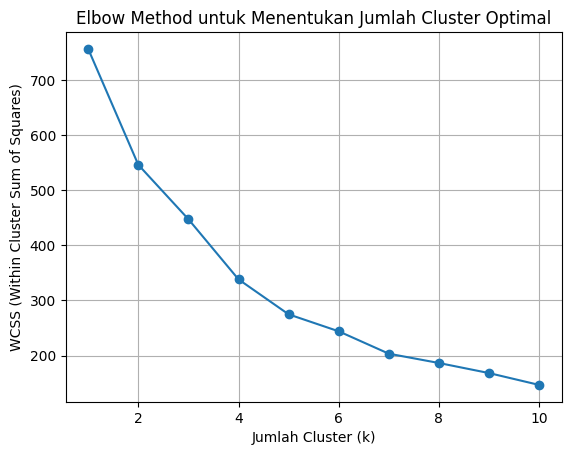

In [65]:
wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(X_scaled)
    wcss.append(kmeans_temp.inertia_)

plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method untuk Menentukan Jumlah Cluster Optimal")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("WCSS (Within Cluster Sum of Squares)")
plt.grid(True)
plt.show()

In [66]:
# buatkan modeling menggunakan algoritma ML
df = pd.read_csv("MALARIA_gabungan.csv")

features = [
    'jumlah_kasus',
    'jumlah_puskesmas',
    'persentase_sanitasi_layak',
    'kepadatan_penduduk'
]

X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_cluster=4
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

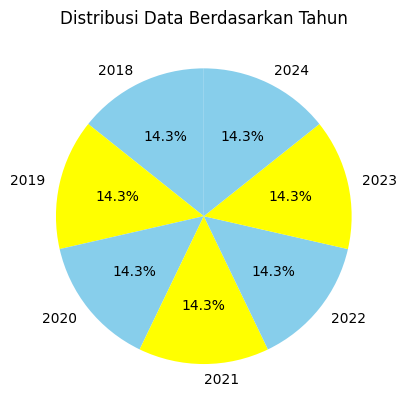

In [67]:
tahun_counts = df['tahun'].value_counts()

plt.pie(
    tahun_counts,
    labels=tahun_counts.index,
    autopct='%1.1f%%',
    colors=['skyblue', 'yellow'],
    startangle=90
)

plt.title("Distribusi Data Berdasarkan Tahun")
plt.show()

C:\Users\anand\AppData\Local\Temp\ipykernel_25972\1905335669.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


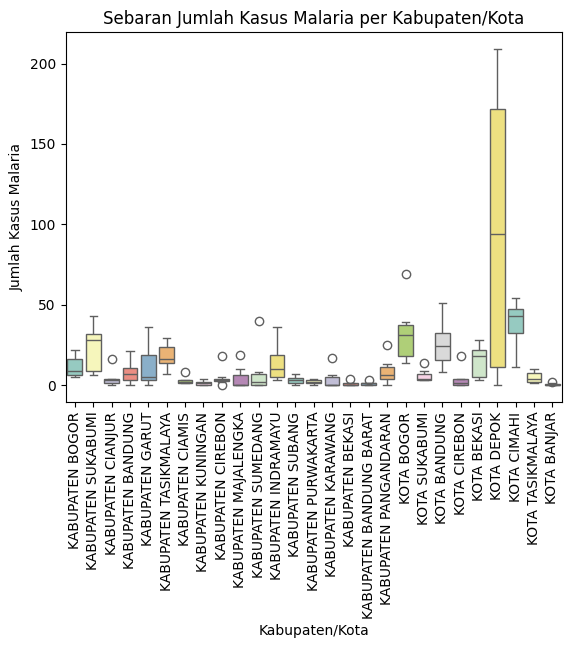

In [68]:
sns.boxplot(
    data=df,
    x='nama_kabupaten_kota',
    y='jumlah_kasus',
    palette='Set3'
)

plt.title("Sebaran Jumlah Kasus Malaria per Kabupaten/Kota")
plt.xlabel("Kabupaten/Kota")
plt.ylabel("Jumlah Kasus Malaria")
plt.xticks(rotation=90)
plt.show()


C:\Users\anand\AppData\Local\Temp\ipykernel_25972\1773363876.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


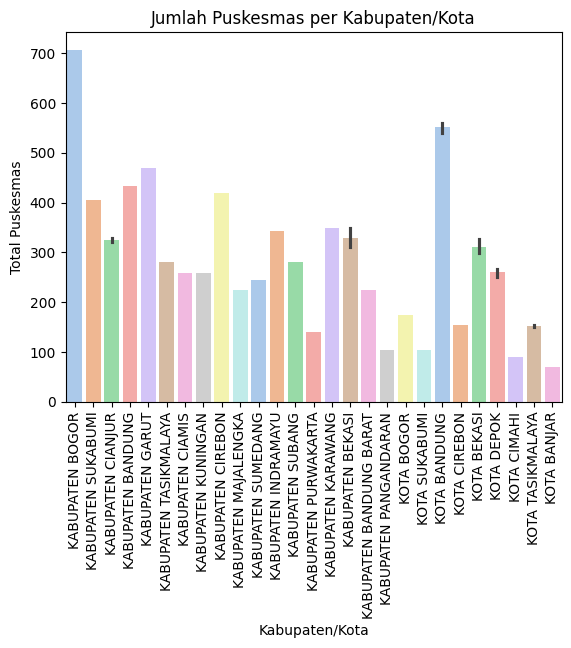

In [69]:
sns.barplot(
    data=df,
    x='nama_kabupaten_kota',
    y='jumlah_puskesmas',
    estimator=sum,
    palette='pastel'
)

plt.title("Jumlah Puskesmas per Kabupaten/Kota")
plt.xlabel("Kabupaten/Kota")
plt.ylabel("Total Puskesmas")
plt.xticks(rotation=90)
plt.show()

C:\Users\anand\AppData\Local\Temp\ipykernel_25972\3738176101.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


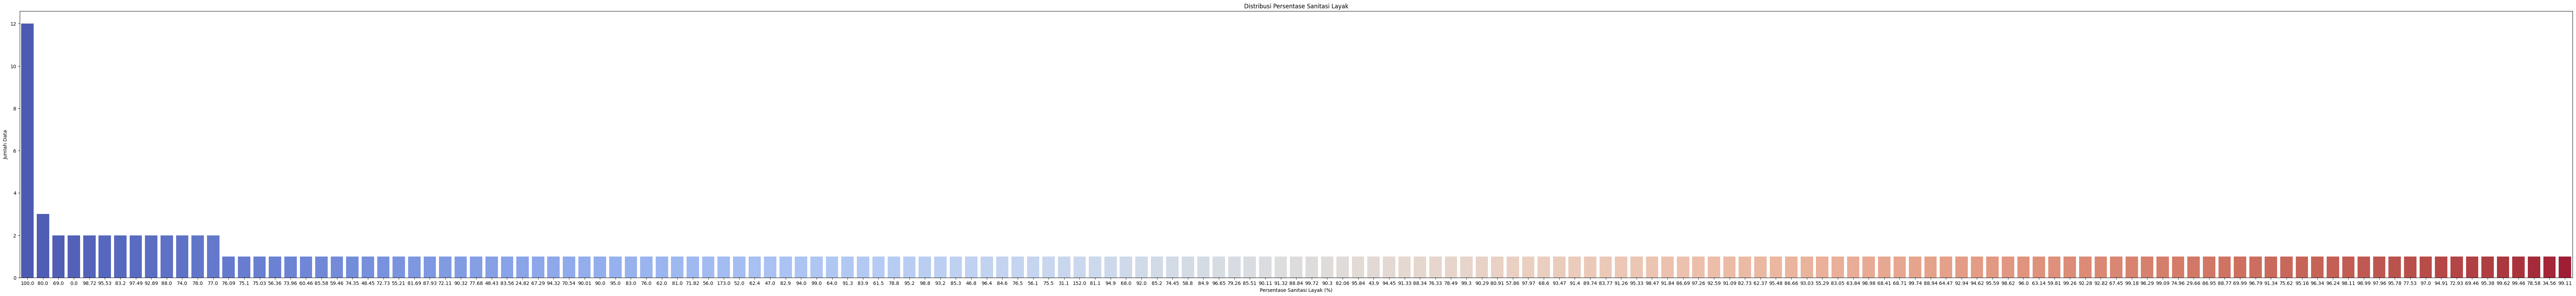

In [70]:
plt.figure(figsize=(95, 10))
sns.countplot(
    data=df,
    x='persentase_sanitasi_layak',
    order=df['persentase_sanitasi_layak'].value_counts().index,
    palette='coolwarm'
)

plt.title("Distribusi Persentase Sanitasi Layak")
plt.xlabel("Persentase Sanitasi Layak (%)")
plt.ylabel("Jumlah Data")
plt.show()

In [71]:
# ada 2 plihihan bisa menggunakan supervised learning / unsupervised learning

# Evaluation

## Model evaluation classification / clustering

In [72]:
# tentukan metode evaluasi yang digunakan dan berikan penjelasan terhadap hasil evaluasinya

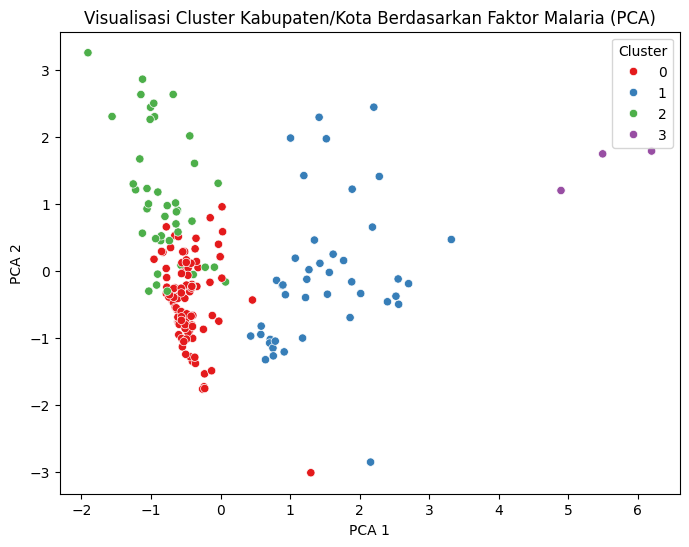

In [73]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=components[:, 0],
    y=components[:, 1],
    hue=df['Cluster'],
    palette='Set1'
)

plt.title("Visualisasi Cluster Kabupaten/Kota Berdasarkan Faktor Malaria (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

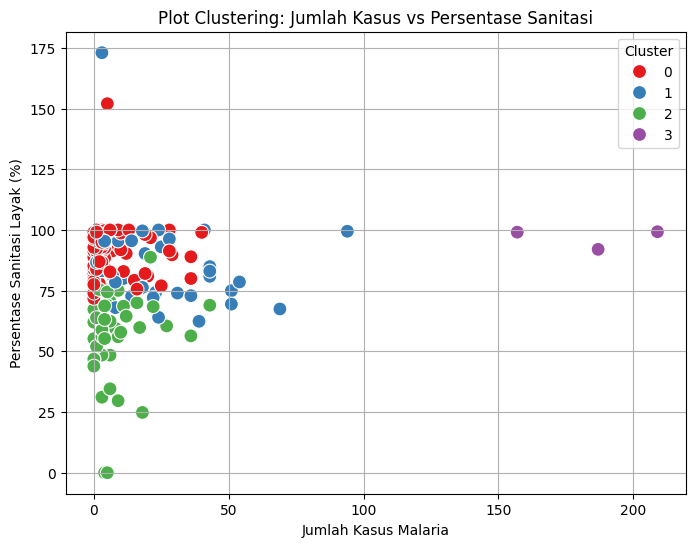

In [74]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='jumlah_kasus',
    y='persentase_sanitasi_layak',
    hue='Cluster',
    palette='Set1',
    s=100
)

plt.title("Plot Clustering: Jumlah Kasus vs Persentase Sanitasi")
plt.xlabel("Jumlah Kasus Malaria")
plt.ylabel("Persentase Sanitasi Layak (%)")
plt.grid(True)
plt.show()

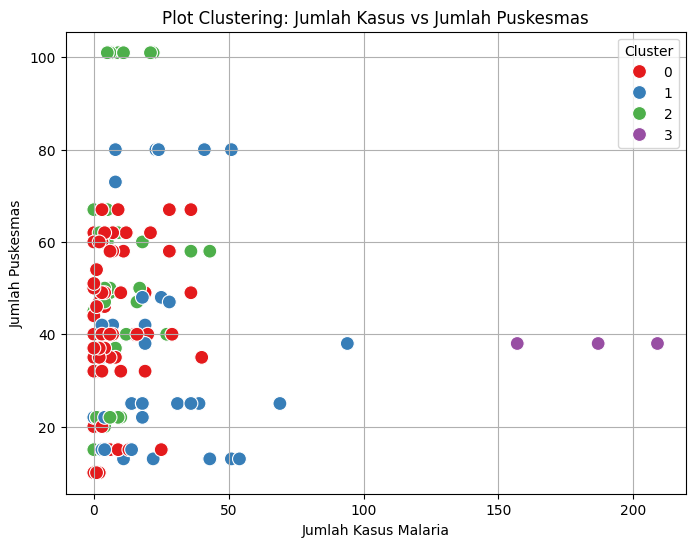

In [75]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='jumlah_kasus',
    y='jumlah_puskesmas',
    hue='Cluster',
    palette='Set1',
    s=100
)

plt.title("Plot Clustering: Jumlah Kasus vs Jumlah Puskesmas")
plt.xlabel("Jumlah Kasus Malaria")
plt.ylabel("Jumlah Puskesmas")
plt.grid(True)
plt.show()

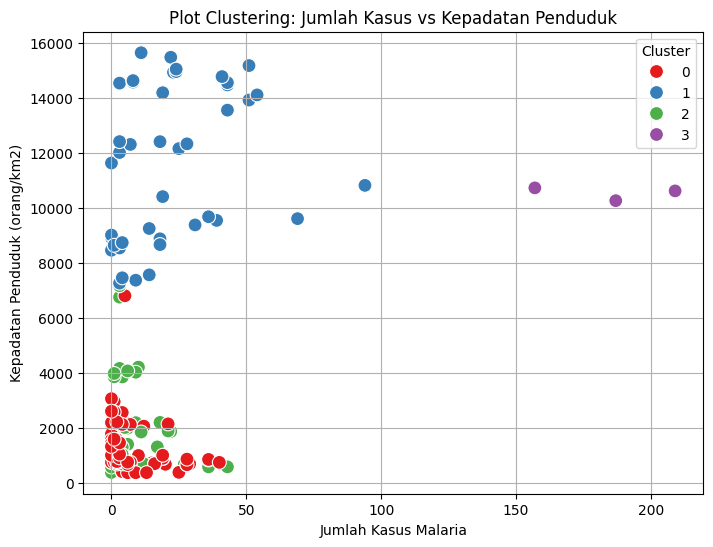

In [76]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='jumlah_kasus',
    y='kepadatan_penduduk',
    hue='Cluster',
    palette='Set1',
    s=100
)

plt.title("Plot Clustering: Jumlah Kasus vs Kepadatan Penduduk")
plt.xlabel("Jumlah Kasus Malaria")
plt.ylabel("Kepadatan Penduduk (orang/km2)")
plt.grid(True)
plt.show()


Memulai perhitungan klastering...
k     Silhouette      Davies-Bouldin 
-----------------------------------
2     0.4061          1.2978         
3     0.4044          0.9345         
4     0.3622          0.9939         
5     0.4008          0.8969         
6     0.3509          0.8607         
7     0.3302          0.8192         
8     0.3366          0.8944         
9     0.3473          0.8954         
10    0.3669          0.8548         

File 'hasil_evaluasi_klastering.csv' berhasil disimpan.


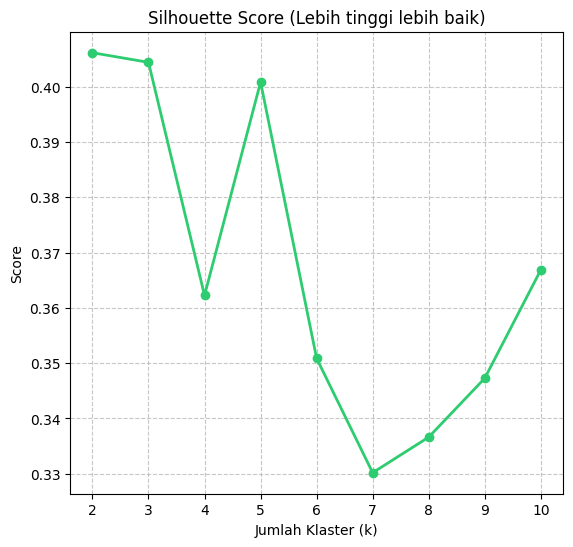

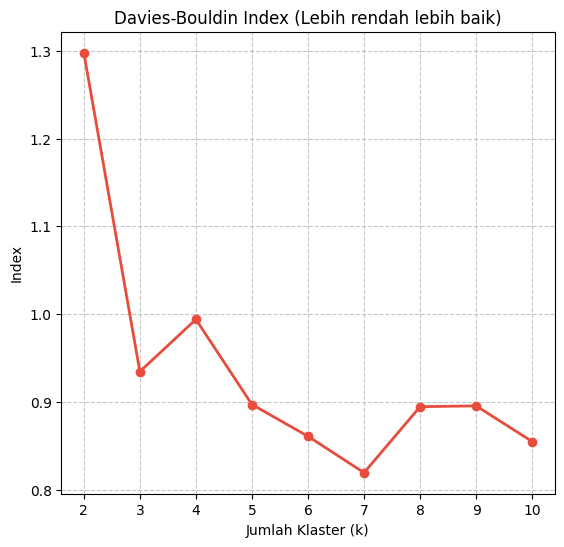

In [77]:
# untuk unsupervised bisa gunakan sillouete atau davies bouldin
features = ['jumlah_kasus', 'persentase_sanitasi_layak', 'jumlah_puskesmas', 'kepadatan_penduduk']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette_scores = []
db_scores = []
k_values = range(2, 11)

print("\nMemulai perhitungan klastering...")
print(f"{'k':<5} {'Silhouette':<15} {'Davies-Bouldin':<15}")
print("-" * 35)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)
    
    silhouette_scores.append(sil_score)
    db_scores.append(db_score)
    
    print(f"{k:<5} {sil_score:<15.4f} {db_score:<15.4f}")

metrics_df = pd.DataFrame({
    'Jumlah_Klaster_k': k_values,
    'Silhouette_Score': silhouette_scores,
    'Davies_Bouldin_Index': db_scores
})
metrics_df.to_csv('hasil_evaluasi_klastering.csv', index=False)
print("\nFile 'hasil_evaluasi_klastering.csv' berhasil disimpan.")

# Plot Silhouette Score
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o', color='#2ecc71', linewidth=2)
plt.title('Silhouette Score (Lebih tinggi lebih baik)')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot Davies-Bouldin Index
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.plot(k_values, db_scores, marker='o', color='#e74c3c', linewidth=2)
plt.title('Davies-Bouldin Index (Lebih rendah lebih baik)')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [78]:
df = pd.read_csv('MALARIA_gabungan.csv')

features = ['jumlah_kasus', 'persentase_sanitasi_layak', 'jumlah_puskesmas', 'kepadatan_penduduk']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_cluster = 4
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
raw_labels = kmeans.fit_predict(X_scaled)

df['Temp_Cluster'] = raw_labels
cluster_means = df.groupby('Temp_Cluster')['jumlah_kasus'].mean().sort_values()
mapping_new_id = {}
for new_label, old_label in enumerate(cluster_means.index):
    mapping_new_id[old_label] = new_label

df['Cluster_ID'] = df['Temp_Cluster'].map(mapping_new_id)
df.drop(columns=['Temp_Cluster'], inplace=True)

score = silhouette_score(X_scaled, df['Cluster_ID'])
print(f"\nSilhouette Score: {score:.4f}")

summary = df.groupby('Cluster_ID')[features].mean()
print("\nRata-rata per Cluster:")
print(summary)


risk_names = {}
if n_cluster == 2:
    risk_names = {0: 'Rawan Rendah', 1: 'Rawan Tinggi'}
elif n_cluster == 3:
    risk_names = {0: 'Rawan Rendah', 1: 'Rawan Sedang', 2: 'Rawan Tinggi'}
elif n_cluster == 4:
    risk_names = {0: 'Sangat Rendah', 1: 'Rendah', 2: 'Sedang', 3: 'Tinggi'}
else:
    # Nama otomatis untuk K > 4
    for i in range(n_cluster):
        if i == 0: risk_names[i] = "Risiko Terendah"
        elif i == n_cluster - 1: risk_names[i] = "Risiko Tertinggi"
        else: risk_names[i] = f"Level Risiko {i}"

df['Kategori_Resiko'] = df['Cluster_ID'].map(risk_names)

df.to_csv('MALARIA_hasil_clustering.csv', index=False)
print("File tersimpan: MALARIA_hasil_clustering.csv")

print("\nPreview Hasil:")
print(df[['nama_kabupaten_kota', 'jumlah_kasus', 'Kategori_Resiko']].head(10))


Silhouette Score: 0.3622

Rata-rata per Cluster:
            jumlah_kasus  persentase_sanitasi_layak  jumlah_puskesmas  \
Cluster_ID                                                              
0               6.089109                  91.120594         38.851485   
1               8.309524                  56.543571         51.000000   
2              22.000000                  87.361163         34.651163   
3             184.333333                  96.783333         38.000000   

            kepadatan_penduduk  
Cluster_ID                      
0                  1232.029703  
1                  2070.238095  
2                 11556.976744  
3                 10540.333333  
File tersimpan: MALARIA_hasil_clustering.csv

Preview Hasil:
     nama_kabupaten_kota  jumlah_kasus Kategori_Resiko
0        KABUPATEN BOGOR             7          Rendah
1     KABUPATEN SUKABUMI            36          Rendah
2      KABUPATEN CIANJUR             0   Sangat Rendah
3      KABUPATEN BANDUNG        

# Deployment

## Model Simulation

In [79]:
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)
feature_names = [f'Fitur_{i}' for i in range(1, 11)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

Accuracy  : 0.8800
Precision : 0.8822
Recall    : 0.8800
F1 Score  : 0.8803

Laporan Klasifikasi Lengkap:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        89
           1       0.91      0.86      0.89       111

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



Text(0.5, 1.0, 'Confusion Matrix Evaluasi Model')

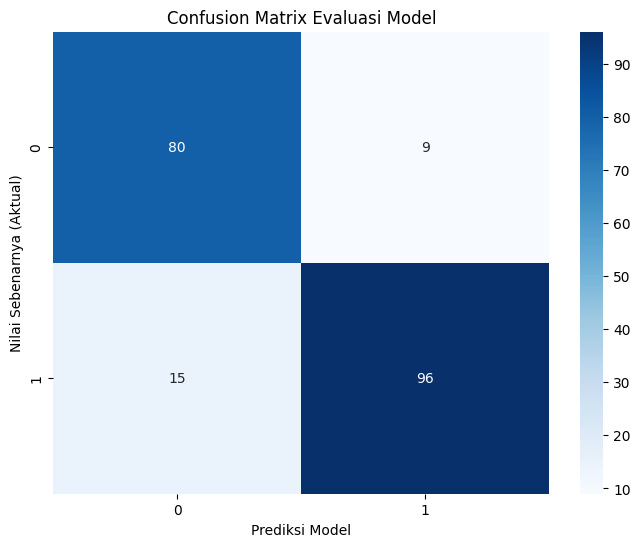

In [80]:
# simulasika model dengan inputan data baru
y_pred = model.predict(X_test)

# A. Metrics Dasar (gunakan average='weighted' untuk multi-class)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_test, y_pred, zero_division=0))

# B. Confusion Matrix (Visualisasi)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi Model')
plt.ylabel('Nilai Sebenarnya (Aktual)')
plt.title('Confusion Matrix Evaluasi Model')

## Save Model

In [81]:
# simpan model sebelum dilanjutkan ke aplikasi streamlit
filename = 'final_model_rf0.pkl'

# Paket Model Lengkap
# Kita simpan model beserta nama fiturnya agar tidak tertukar saat deployment nanti
all_possible_risk_names = {}

for k in range(2, 11): # Menyiapkan skenario untuk K=2 sampai K=10
    names = {}
    if k == 2:
        names = {0: 'Rawan Rendah', 1: 'Rawan Tinggi'}
    elif k == 3:
        names = {0: 'Rawan Rendah', 1: 'Rawan Sedang', 2: 'Rawan Tinggi'}
    elif k == 4:
        names = {0: 'Sangat Rendah', 1: 'Rendah', 2: 'Sedang', 3: 'Tinggi'}
    else:
        # Logika otomatis untuk K >= 5
        for i in range(k):
            if i == 0: names[i] = "Risiko Terendah"
            elif i == k - 1: names[i] = "Risiko Tertinggi"
            else: names[i] = f"Level Risiko {i}"
   
    all_possible_risk_names[k] = names
    model_package = {
    'features': features,
    'scaler':scaler,
    'all_possible_risk_names': all_possible_risk_names,
    'K_range': list(K_range),
    'wcss': wcss

    
}

# Simpan ke file .pkl (Write Binary)
with open(filename, 'wb') as file:
    pickle.dump(model_package, file)

print(f"Model berhasil disimpan ke file: {filename}")
print("File ini siap dikirim ke tim engineering/web developer.")
print("----------------------------------\n")

Model berhasil disimpan ke file: final_model_rf0.pkl
File ini siap dikirim ke tim engineering/web developer.
----------------------------------

